# Titanic spaceship

## Introduction

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

cf [here](https://www.kaggle.com/competitions/spaceship-titanic)

# Import data

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

In [2]:
df = pd.read_csv("./train.csv")
df.head(6000)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,6346_01,Mars,False,F/1212/S,TRAPPIST-1e,29.0,False,2223.0,0.0,0.0,0.0,0.0,Guanch Perta,False
5996,6346_02,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta,False
5997,6347_01,Earth,True,G/1030/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,Andie Gambs,True
5998,6348_01,Europa,False,C/238/S,55 Cancri e,NaN,False,49.0,13342.0,NaN,1885.0,6985.0,Achira Unhaftimle,False


In [83]:
def wrangling_data(path):
    # clean data, remove unused informations
    df = pd.read_csv(path)
    df.drop(["ShoppingMall", "Spa", "VRDeck", "Name", "Age"], axis=1, inplace=True)
    # slice group id & passenger id
    df[["GroupId", "PersonId"]] = df["PassengerId"].str.split("_", n=1, expand=True)
    df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", n=2, expand=True)
    # drop unused columns
    # drop personId ??
    df.drop(["PassengerId", "Cabin"], axis=1, inplace=True)
    df[['VIP', 'CryoSleep']] = df[['VIP', 'CryoSleep']].fillna(value=0)

    # one-hot-encoding or integer encoding
    # here we're using one-hot-encoding
    home_planet = pd.get_dummies(df["HomePlanet"], prefix="HomePlanet")
    destination = pd.get_dummies(df["Destination"], prefix="Destination")
    df = pd.concat([df, home_planet, destination], axis=1)
    # integer encoding with LabelEncoder
    encoder = LabelEncoder()
    df["CabinDeck"] = encoder.fit_transform(df["CabinDeck"])
    df["CabinSide"] = encoder.fit_transform(df["CabinSide"])
    if "Transported" in df.index.values:
        df["Transported"] = encoder.fit_transform(df["Transported"])
    df["GroupId"] = encoder.fit_transform(df["GroupId"])
    df["CabinNum"] = encoder.fit_transform(df["CabinNum"])
    df["VIP"] = encoder.fit_transform(df["VIP"])
    df["CryoSleep"] = encoder.fit_transform(df["CryoSleep"])
    # drop columns
    df.drop(["HomePlanet", "Destination"], axis=1, inplace=True)
    df.head()
    return df.fillna(value=0)

<Axes: >

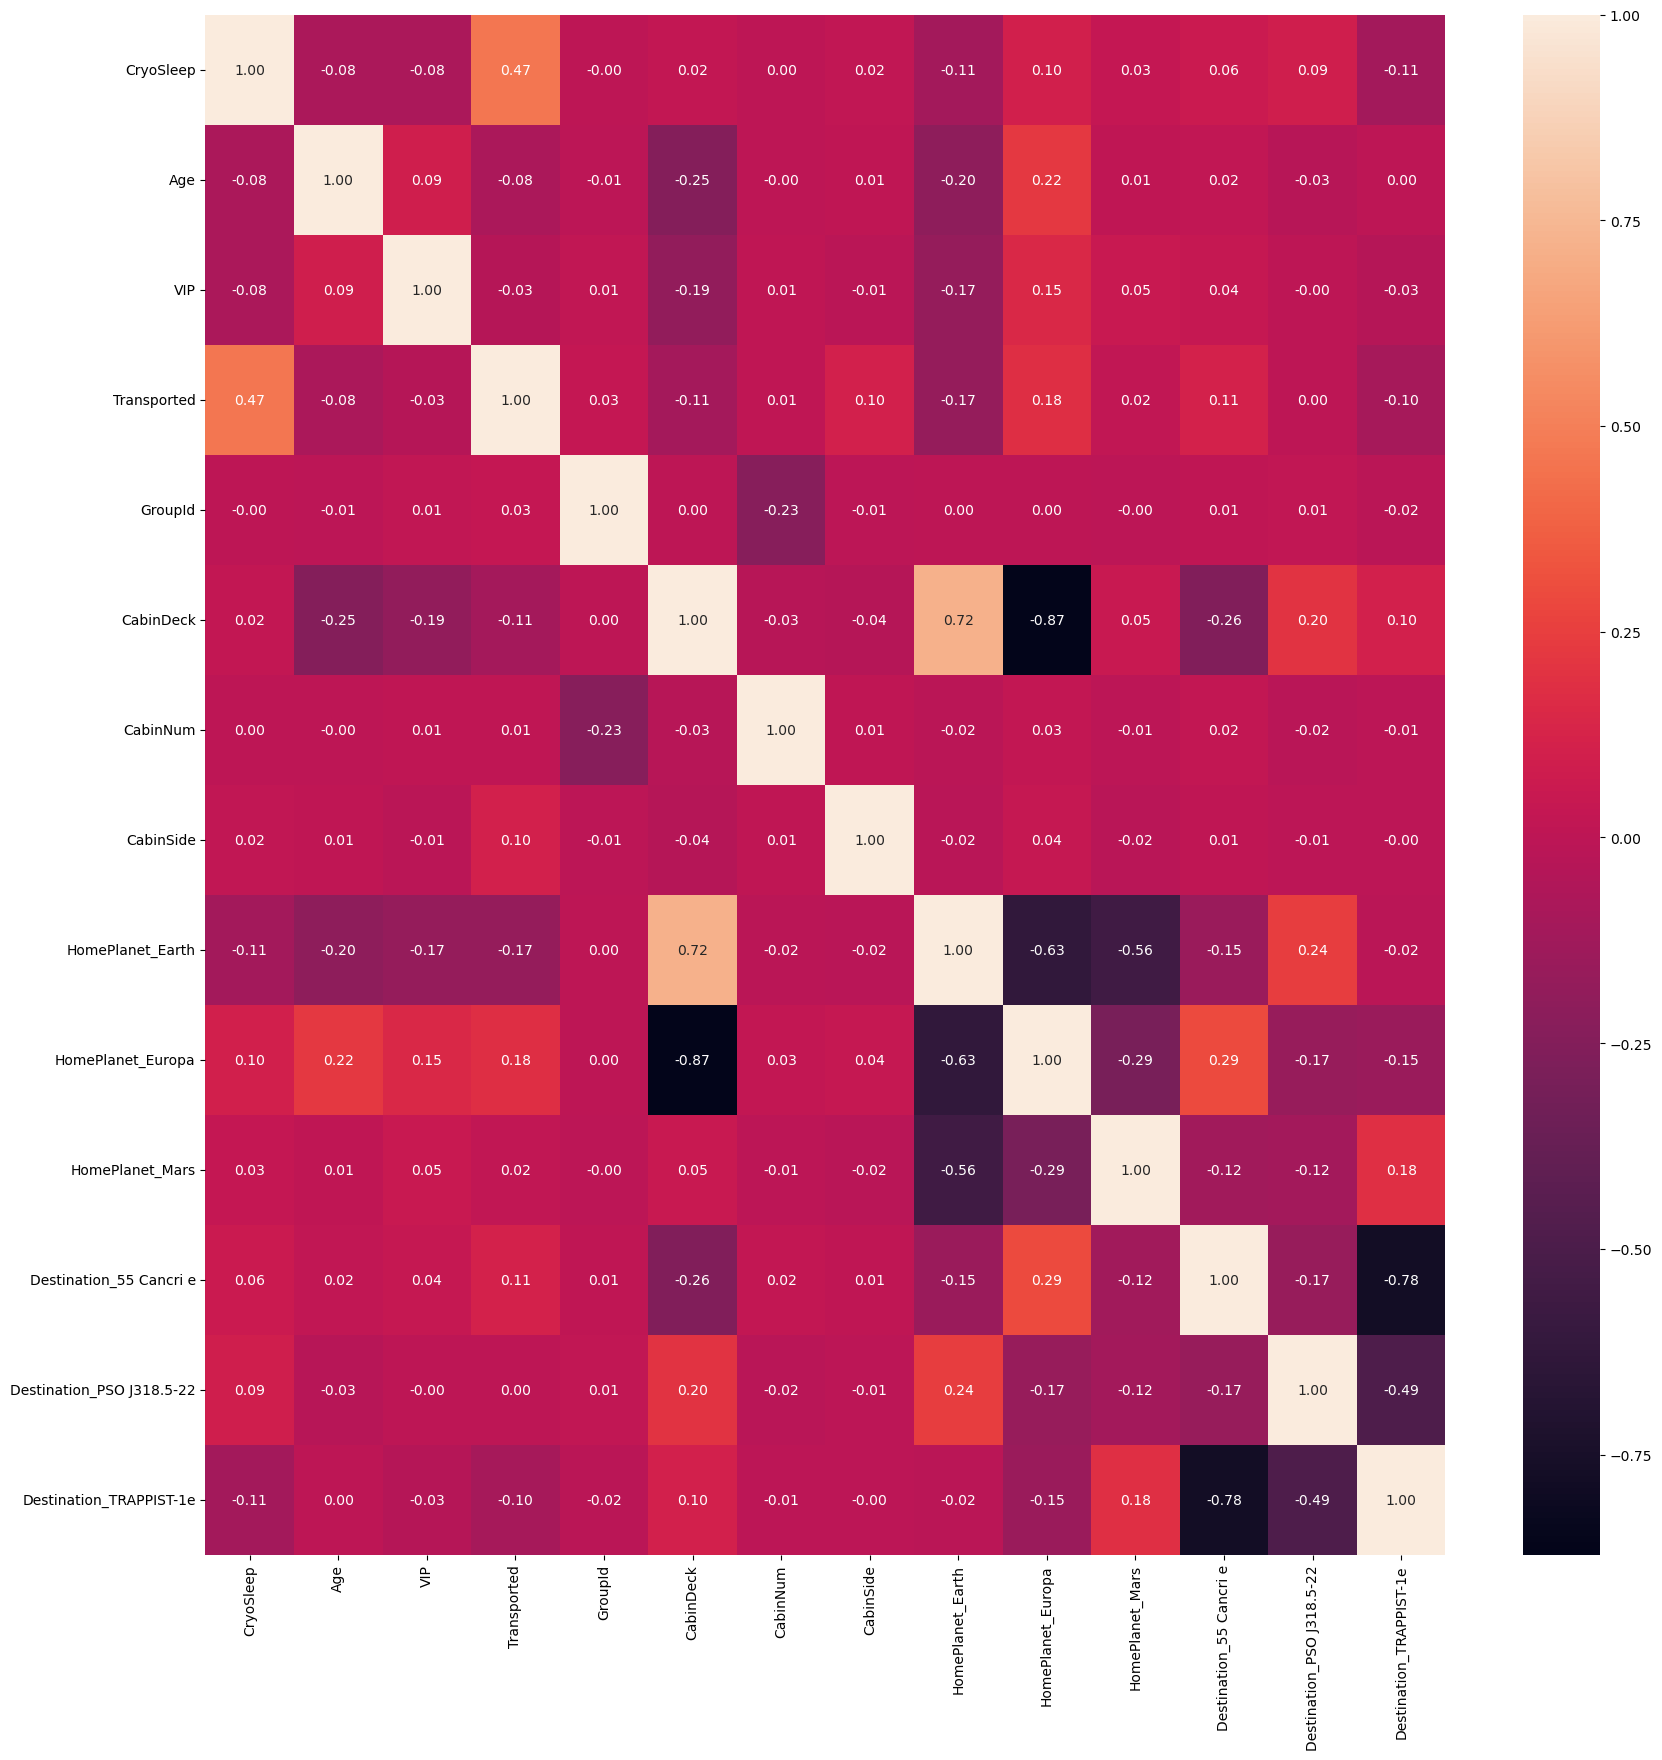

In [10]:
# correlation
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), annot = True, fmt= '.2f')

In [18]:
df[(df["CryoSleep"] == 1) & (df["Transported"] == 0)].count()

CryoSleep                    490
Age                          490
VIP                          490
Transported                  490
GroupId                      490
CabinDeck                    490
CabinNum                     490
CabinSide                    490
HomePlanet_Earth             490
HomePlanet_Europa            490
HomePlanet_Mars              490
Destination_55 Cancri e      490
Destination_PSO J318.5-22    490
Destination_TRAPPIST-1e      490
dtype: int64

In [85]:
df = wrangling_data("./train.csv")
X = df.drop("Transported", axis=1)
y = df["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

C:\Users\adrie\AppData\Local\Temp\ipykernel_13660\215849415.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "Transported" in df.index.values:


In [86]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of decision trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be a leaf node
}

# Create a random forest classifier
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print('Best hyperparameters:',  best_params)
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)

accuracy = best_rf_classifier.score(X_test, y_test)

print("Accuracy:", accuracy)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7561817136285222


In [73]:
test_data = pd.read_csv("./test.csv")
test_data.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name"], axis=1, inplace=True)
test_data[test_data.isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP
18,0047_02,Europa,False,NaN,TRAPPIST-1e,29.0,False
42,0100_01,Earth,False,G/13/P,TRAPPIST-1e,NaN,NaN
68,0156_01,Mars,NaN,F/34/P,TRAPPIST-1e,NaN,False
78,0175_02,Earth,NaN,G/25/P,55 Cancri e,8.0,False
92,0208_01,Earth,NaN,G/33/P,TRAPPIST-1e,40.0,False
...,...,...,...,...,...,...,...
4258,9238_05,Earth,True,NaN,TRAPPIST-1e,14.0,False
4267,9260_01,Earth,True,G/1503/P,55 Cancri e,3.0,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False


In [87]:
test_data = wrangling_data("./test.csv")
print(test_data.shape)
predictions = best_rf_classifier.predict(test_data)
print(predictions)
print(test_data.head(2000))

(4277, 15)
[ True False  True ...  True False  True]
      CryoSleep  VIP  RoomService  FoodCourt  GroupId PersonId  CabinDeck  \
0             1    0          0.0        0.0        0       01          6   
1             0    0          0.0        9.0        1       01          5   
2             1    0          0.0        0.0        2       01          2   
3             0    0          0.0     6652.0        3       01          2   
4             0    0         10.0        0.0        4       01          5   
...         ...  ...          ...        ...      ...      ...        ...   
1995          0    0         18.0        0.0     1412       02          4   
1996          0    0          0.0        0.0     1413       01          5   
1997          0    1        430.0        0.0     1414       01          4   
1998          1    0          0.0        0.0     1414       02          5   
1999          1    0          0.0        0.0     1414       03          5   

      CabinNum  CabinS

C:\Users\adrie\AppData\Local\Temp\ipykernel_13660\215849415.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "Transported" in df.index.values:


In [88]:
sample = pd.read_csv("./sample_submission.csv")
print(sample.shape)
sample["Transported"] = predictions
sample.to_csv("./sample_submission.csv", index=False)

(4277, 2)
